# Kalman Filter

This example optimizes the parameters of a [Kalman-Filter](https://en.wikipedia.org/wiki/Kalman_filter).

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/kalman_filter.ipynb).

In [3]:
from types import SimpleNamespace
from typing import Optional

import diffrax as dfx
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax.numpy as jnp
import jax.random as jr
import jax.tree_util as jtu
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

from jax import jacrev

from control import lqr,ctrb,obsv,lqe

We use [Equinox](https://github.com/patrick-kidger/equinox) to build the Kalman-Filter implementation and to represent linear, time-invariant systems (LTI systems). 

We use [Optax](https://github.com/deepmind/optax) for optimisers (Adam etc.)

## Problem Formulation

Assume that there exists some *unknown* dynamical system of the form

$\frac{dx}{dt}(t)= f(x(t), u(t), t)$

$y(t) = g(x(t)) + \epsilon(t)$ 

where 
- $u(t)$ denotes the time-dependent input to the system
- $y(t)$ denotes the time-dependent output / measurement to the system
- $x(t)$ denotes the time-dependent state of the system (which is not directly measureable in general)
- $f,g$ denote the time-dependent dynamics- and measurement-function, respectively
- $\epsilon$ denotes random measurement uncertainty

*The goal is to infer $x$ from $y$ even though $f,g,\epsilon$ are unkown.*

*A Kalman-Filter represents a possible solution.*


!!! info

    From [Wikipedia](https://en.wikipedia.org/wiki/Kalman_filter): 
    
    Kalman filtering, also known as linear quadratic estimation (LQE), is an algorithm that uses a series of measurements observed over time, including statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each timeframe. The filter is named after Rudolf E. Kálmán, who was one of the primary developers of its theory.

    The algorithm works by a two-phase process. For the prediction phase, the Kalman filter produces estimates of the current state variables, along with their uncertainties. Once the outcome of the next measurement (necessarily corrupted with some error, including random noise) is observed, these estimates are updated using a weighted average, with more weight being given to estimates with greater certainty. The algorithm is recursive. It can operate in real time, using only the present input measurements and the state calculated previously and its uncertainty matrix; no additional past information is required.
    

For the sake of simplicity, here we assume that the dynamical system takes the form

$\frac{dx}{dt}(t) = Ax(t) + Bu(t)$

$y(t) = Cx(t) + \epsilon(t)$ 

where $A,B,C$ are constant matrices, i.e. the system is linear in its state $x(t)$ and its input $u(t)$. Further, the dynamics- and measurement-functions do not depend on time.

Hence, the above represents the general form of (physical) *linear, time-invariant systems* (LTI systems).

Here we define a container object for LTI systems.

An harmonic oscillator is an LTI system, this function returns such an LTI system.

Here we define some utility functions that allow us to simulate LTI systems.

In [4]:
def interpolate_us(ts, us, B):
    if us is None:
        m = B.shape[-1]
        u_t = SimpleNamespace(evaluate=lambda t: jnp.zeros((m,)))
    else:
        u_t = dfx.LinearInterpolation(ts=ts, ys=us)
    return u_t


def diffeqsolve(
    rhs,
    ts: jnp.ndarray,
    y0: jnp.ndarray,
    solver: dfx.AbstractSolver = dfx.Dopri5(),
    stepsize_controller: dfx.AbstractStepSizeController = dfx.ConstantStepSize(),
    dt0: float = 0.01,
) -> jnp.ndarray:
    return dfx.diffeqsolve(
        dfx.ODETerm(rhs),
        solver=solver,
        stepsize_controller=stepsize_controller,
        t0=ts[0],
        t1=ts[-1],
        y0=y0,
        dt0=dt0,
        saveat=dfx.SaveAt(ts=ts),
        max_steps = 10000
    ).ys



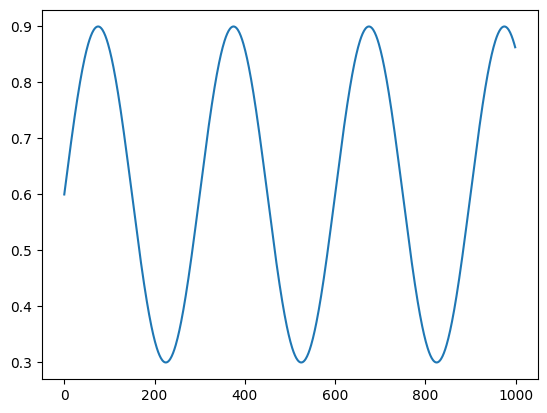

In [6]:
betas = [0.6 + 0.3 * jnp.sin(2 * jnp.pi * (t % 30) / 30) for t in jnp.arange(0,100,0.1)]
plt.plot(betas)

In [8]:
def SIR(t,x,args):
    beta = 0.6 + 0.3 * jnp.sin(2 * jnp.pi * (t % 30) / 30)
    N = x[0]+ x[1]+ x[2]
    return jnp.array([-(beta * x[0] * x[1])/N,(beta * x[0] * x[1])/N - 0.1 * x[1],0.1 * x[1]])

In [9]:
def SIR_jac(x,par):
    N = x[0]+ x[1]+ x[2]
    return jnp.array([-(par[0] * x[0] * x[1])/N,(par[0] * x[0] * x[1])/N - par[1] * x[1],par[1] * x[1]])

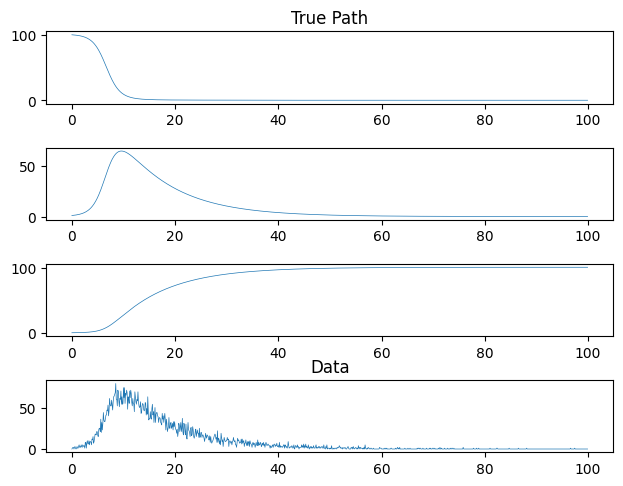

In [10]:
###Data
key = jr.PRNGKey(0)
key,data_noise_key = jr.split(key)

ts = jnp.arange(0,100,0.1)
xs = diffeqsolve(SIR,ts = ts, y0 = jnp.array([100.,1.,0.]))

fig, axs = plt.subplots(4)
fig.tight_layout()

axs[0].set_title('True Path')
for i in range(3):
    axs[i].plot(ts,xs[:,i],lw = 0.5)

axs[3].set_title('Data')
ys = jr.poisson(data_noise_key,xs[:,1])
axs[3].plot(ts,ys,lw = 0.5)

Here we define the Kalman-Filter.

Note how we use `equinox` to combine the Kalman-Filter logic in `__call__` and the Kalman-Filter parameters $Q$ , $R$ in one object.

The matrices $Q$ and $R$ must be positive-definite. To ensure that this property always holds, we fit a matrices $Q'$ and $R'$ instead, and obtain $Q$ and $R$ from their matrix-matrix products. (I.e. $Q = Q'^T \cdot Q'$, with $Q'$ square.)

In [24]:
class KalmanFilter(eqx.Module):
    """Continuous-time Kalman Filter

    Ref:
        [1] Optimal and robust estimation. 2nd edition. Page 154.
        https://lewisgroup.uta.edu/ee5322/lectures/CTKalmanFilterNew.pdf
    """

    x0: jnp.ndarray
    P0: jnp.ndarray
    Q_root: jnp.ndarray  # "matrix roots" to ensure that Q, R are positive definite
    R_root: jnp.ndarray
    
    par: jnp.ndarray

    def __call__(self, ts, ys, us: Optional[jnp.ndarray] = None):

        A = jacrev(SIR_jac)
        B = jnp.array([[0.0],[1.0],[0.0]])
        C = jnp.array([[0.0,1.0,0.0]])

        y_t = dfx.LinearInterpolation(ts=ts, ys=ys)
        u_t = interpolate_us(ts, us, B)

        y0 = (self.x0, self.P0)

        def rhs(t, y, args):
            x, P = y

            par = self.par**2

            # eq 3.22 of Ref [1]
            R = self.R_root.T @ self.R_root
            K = P @ C.transpose() @ jnp.linalg.inv(R)

            # eq 3.21 of Ref [1]
            Q = self.Q_root.T @ self.Q_root
            dPdt = (
                A(x,par) @ P
                + P @ A(x,par).transpose()
                + Q
                - P @ C.transpose() @ jnp.linalg.inv(R) @ C @ P
            )

            # eq 3.23 of Ref [1]
            dxdt = SIR_jac(x,par) + B @ u_t.evaluate(t) + K @ (y_t.evaluate(t) - C @ x)

            return (dxdt, dPdt)

        return diffeqsolve(rhs, ts, y0)[0]

In [25]:
step_schedule = [100]
lr_schedule = [1e-2]
print_every = 1

In [26]:
Q_root=jnp.diag(jnp.ones((3,))) * 5.0
# weighs how much we trust in the measurements of the system
R_root=jnp.diag(jnp.ones((1,))) * 5.0
# weighs how much we trust our initial guess
P0=jnp.diag(jnp.ones((3,))) * 5.0

par0 = jnp.array([1.5,0.8])

kmf = KalmanFilter(jnp.array([100.,1.,0.]), P0, Q_root, R_root,par0)

initial_Q = kmf.Q_root.T @ kmf.Q_root
initial_R = kmf.R_root.T @ kmf.R_root
print(f"Initial Q: \n{initial_Q}\n Initial R: \n{initial_R}\n")

# gradients should only be able to change Q/R parameters
# *not* the model (well at least not in this example :)
filter_spec = jtu.tree_map(lambda arr: False, kmf)
filter_spec = eqx.tree_at(
    lambda tree: (tree.par,tree.Q_root,tree.R_root), filter_spec, replace=(True,True,True)
)

@eqx.filter_value_and_grad
def loss_fn(dynamic_kmf, static_kmf, ts, ys, xs):
    kmf = eqx.combine(dynamic_kmf, static_kmf)
    xhats = kmf(ts, ys)
    return jnp.mean((ys - xhats[:,1]) ** 2)

@eqx.filter_jit
def make_step(kmf, opt_state, ts, ys, xs):
    dynamic_kmf, static_kmf = eqx.partition(kmf, filter_spec)
    value, grads = loss_fn(dynamic_kmf, static_kmf, ts, ys, xs)
    updates, opt_state = opt.update(grads, opt_state)
    kmf = eqx.apply_updates(kmf, updates)
    return value, kmf, opt_state

for lr,steps in zip(lr_schedule, step_schedule):
    opt = optax.adabelief(lr)
    opt_state = opt.init(kmf)

    for step in range(steps):
        value, kmf, opt_state = make_step(kmf, opt_state, ts, ys, xs)
        if step % print_every == 0:
            print(f"Step {step}: MSE: {value}")

final_Q = kmf.Q_root.T @ kmf.Q_root
final_R = kmf.R_root.T @ kmf.R_root
print(f"Final Q: \n{final_Q}\n Final R: \n{final_R}\n")


Initial Q: 
[[25.  0.  0.]
 [ 0. 25.  0.]
 [ 0.  0. 25.]]
 Initial R: 
[[25.]]



Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10a2838c0>>
Traceback (most recent call last):
  File "/Users/averydrennan/Downloads/NODES/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Main entry point. Try runnning `main()`.

We can see that the MSE is smaller after optimization. 

After optimization we trust the measurements more as there is a significant modeling error.

We can observe this nicely through the added noise in our state estimate. Recall that the measurements are noisy after all.

Text(0.5, 1.0, 'Kalman-Filter optimization w.r.t Q/R')

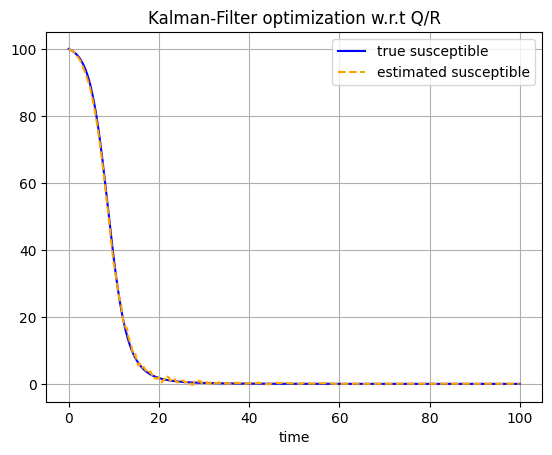

In [ ]:
xhats = kmf(ts, ys)
plt.plot(ts, xs[:, 0], label="true susceptible", color="blue")
plt.plot(
    ts,
    xhats[:, 0],
    label="estimated susceptible",
    color="orange",
    linestyle="dashed",
)

plt.xlabel("time")
plt.grid()
plt.legend()
plt.title("Kalman-Filter optimization w.r.t Q/R")


Text(0.5, 1.0, 'Kalman-Filter optimization w.r.t params [0.6125402  0.10145935]')

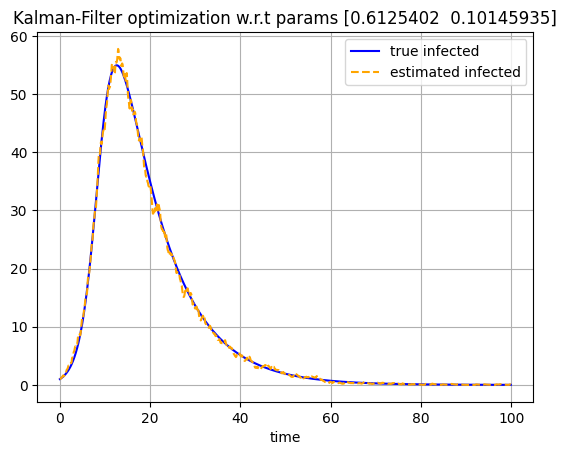

In [ ]:
plt.plot(ts, xs[:, 1], label="true infected", color="blue")
plt.plot(
    ts,
    xhats[:, 1],
    label="estimated infected",
    color="orange",
    linestyle="dashed",
)

plt.xlabel("time")
plt.grid()
plt.legend()
plt.title(f"Kalman-Filter optimization w.r.t params {kmf.par**2}")

Text(0.5, 1.0, 'Kalman-Filter optimization w.r.t Q/R')

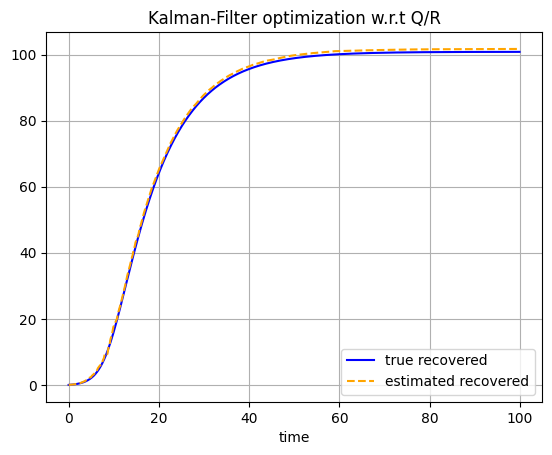

In [ ]:
plt.plot(ts, xs[:, 2], label="true recovered", color="blue")
plt.plot(
    ts,
    xhats[:, 2],
    label="estimated recovered",
    color="orange",
    linestyle="dashed",
)

plt.xlabel("time")
plt.grid()
plt.legend()
plt.title("Kalman-Filter optimization w.r.t Q/R")